# Expected Points (xP) 

The expected points (xP) model is a tool used to estimate the likely outcome of a football match based on each team’s expected goals (xG). xG is a key metric in football analytics that estimates the quality of goal-scoring chances by assigning a probability of scoring from each shot taken. The main focus of the xP model is not on the final match result but on evaluating the probabilities of winning, losing, or drawing based on the chances created during the game.

Therefore, the xP model uses the Poisson distribution to simulate the number of goals each team is expected to score based on their xG. The Poisson distribution models the probability of a given number of events (in this case, goals) occurring within a fixed interval (a match) when the average event rate (xG) is known. This distribution helps calculate the probabilities for various match outcomes (win, draw, or loss) by evaluating all possible scorelines.

The model then combines these probabilities to determine the expected points (xP) a team should earn from a match, calculated as:

	•	Win Probability (P_win): The chance the team wins the match.
	•	Draw Probability (P_draw): The chance the match ends in a draw.
	•	Loss Probability (P_loss): The chance the team loses the match.

The xP value is calculated by assigning: xP = (3 x P_win) + (1 x P_draw)

This provides a more objective way to estimate team performance based on the quality of chances created and conceded. Some teams may get lucky and win despite creating fewer high-quality chances, while others may be punished despite creating better opportunities. The xP model helps highlight these discrepancies, offering a fairer assessment of performance by focusing on the likelihood of different match outcomes based on actual chances, rather than just the final result.

# Import Libraries

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from sqlalchemy import create_engine
import pymysql
from pymysql.cursors import DictCursor
import pymysql.cursors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve

import xgboost as xgb

from scipy.stats import poisson 

import warnings
warnings.filterwarnings('ignore')

# Query Data

The data used in this model is scraped from WhoScored and stored in a MySQL database. Data cleaning has already been extensively handled in a separate repository, ensuring that inconsistencies and errors have been addressed.

The primary database consists of event-level data, where each row represents a specific action during a match—such as a pass, shot, tackle, or any other significant aspect of the game. This level of data allows us to capture every meaningful event, enabling a comprehensive analysis of match dynamics.

In addition to the event data, a separate team-level database will be used to identify team-specific patterns. By combining both datasets, the model offers deeper insights into team performance and chance creation during matches.

In [2]:
username = 'root'          
password = ''               
host = 'localhost'         
port = '3306'              
database = 'top7_leagues' 

# Create the SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

In [3]:
query = "SELECT * FROM match_events_2023_24"
df_events = pd.read_sql(query, engine)

In [84]:
df_events.columns

Index(['id', 'match_id', 'event_id', 'minute', 'second', 'team_id',
       'player_id', 'x', 'y', 'end_x', 'end_y', 'qualifiers', 'is_touch',
       'blocked_x', 'blocked_y', 'goal_mouth_z', 'goal_mouth_y', 'is_shot',
       'card_type', 'is_goal', 'type_display_name',
       'outcome_type_display_name', 'period_display_name', 'xG', 'own_goal'],
      dtype='object')

In [83]:
df_events.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,xG,own_goal
0,2602361573,1734766,3,0,0.0,54,135366,60.12,40.00,55.68,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
1,2602361601,1734766,4,0,1.0,54,82989,55.32,40.24,38.28,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
2,2602361647,1734766,5,0,4.0,54,125211,38.16,69.52,24.96,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
3,2602361695,1734766,6,0,6.0,54,121456,24.96,55.36,24.12,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
4,2602361767,1734766,7,0,9.0,54,454342,23.28,28.64,21.72,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0


The dataset consists of various columns that capture detailed event-level information during a football match. Key identifiers include id, match_id, event_id, team_id, and player_id, which link events to specific matches, teams, and players. Temporal data is represented by minute and second, while spatial information on the field is recorded with x, y, end_x, and end_y coordinates. Event details are further described by columns like qualifiers, is_touch, blocked_x, blocked_y, goal_mouth_z, goal_mouth_y, and is_shot. Outcome-related data includes card_type, is_goal and outcome_type_display_name

In [4]:
query2 = "SELECT * FROM players_info_2023_24"
df_players = pd.read_sql(query2, engine)

In [5]:
df_teams = df_players[['team_id', 'team_name']].drop_duplicates()

In [85]:
df_teams.columns

Index(['team_id', 'team_name'], dtype='object')

In [86]:
df_teams.head()

,team_id,team_name
0,839,Villarreal
1,211,Brighton
2,51,Mallorca
3,613,Nice
4,31,Everton


The df_teams DataFrame will only be used later in the analysis to merge team names with the event data, replacing team IDs with their corresponding names for easier interpretation and analysis.

# Transform Data

## Add xG Column

In [6]:
def transform_data(df_events):
    
    # Apply transformations to x and y coordinates (intially 100 x 100)
    for col in ['x', 'end_x','blocked_x']:
        df_events.loc[:, col] *= 1.2
    for col in ['y', 'end_y', 'blocked_y', 'goal_mouth_y']:
        df_events.loc[:, col] = 80 - (df_events[col] * 0.8)    

    df_shots = df_events[(df_events['is_shot']==1) & (df_events['x']>40)]

    df_shots.loc[:, 'is_penalty'] = np.where((df_shots['x'] == 106.2) & (df_shots['y'] == 40), 1, 0)
        
    # Goal center coordinates
    goal_x = 120
    goal_y = 40

    # Calculate shot distance & angle

    df_shots['shot_distance'] = np.sqrt((df_shots['x'] - goal_x)**2 + (df_shots['y'] - goal_y)**2)
    
    df_shots['shot_angle'] = np.arctan2(np.abs(df_shots['y'] - goal_y), np.abs(goal_x - df_shots['x']))
    df_shots['shot_angle_deg'] = np.degrees(df_shots['shot_angle'])
    df_shots = df_shots.drop(columns=['shot_angle'])

    return df_shots

In [7]:
def xG_calculation(df_shots):
    
    # Define features and target
    features = ['shot_distance', 'shot_angle_deg','is_penalty','x','y']
    target = 'is_goal'
    
    # Define feature matrix and target vector
    X = df_shots[features]
    y = df_shots[target]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled = X_train  
    X_test_scaled = X_test
    
    xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
    
    xgb_model.fit(X_train_scaled, y_train)
    
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
    
    # Create a subset DataFrame with only the features required for prediction
    df_shots_numeric = df_shots[features]
    
    # Generate xG predictions based on the selected numeric columns
    xg_predictions = xgb_model.predict_proba(df_shots_numeric)[:, 1]  # Get probability for 'goal' (class 1)
    
    #Add the xG predictions back to the original DataFrame
    df_shots['xG'] = xg_predictions

    return df_shots

In [8]:
df_shots = transform_data(df_events)

In [9]:
df_shots = xG_calculation(df_shots)

In [11]:
df_shots.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,is_penalty,shot_distance,shot_angle_deg,xG
75,2602367713,1734766,41,4,13.0,60,370000,117.48,47.68,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,8.082871,71.834043,0.102411
217,2602380121,1734766,99,12,40.0,60,345908,97.32,41.92,NaN,...,1,0,0,SavedShot,Successful,FirstHalf,0,22.761125,4.838899,0.032292
296,2602385821,1734766,151,17,2.0,60,79840,110.04,35.60,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,10.888600,23.834263,0.171072
305,2602386809,1734766,158,17,56.0,60,79840,107.40,35.60,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,13.346160,19.249526,0.121244
395,2602392055,1734766,253,23,46.0,54,395188,108.12,22.88,NaN,...,1,0,0,ShotOnPost,Successful,FirstHalf,0,20.838157,55.242243,0.025924


In [12]:
df_events = pd.merge(df_events,df_shots[['id','xG']],on='id',how='left')
df_events['xG'].fillna(0, inplace=True)

In [13]:
df_events['own_goal'] = np.where((df_events['is_goal']==1) & (df_events['x']<30), 1,0)

In [15]:
df_events.columns

Index(['id', 'match_id', 'event_id', 'minute', 'second', 'team_id',
       'player_id', 'x', 'y', 'end_x', 'end_y', 'qualifiers', 'is_touch',
       'blocked_x', 'blocked_y', 'goal_mouth_z', 'goal_mouth_y', 'is_shot',
       'card_type', 'is_goal', 'type_display_name',
       'outcome_type_display_name', 'period_display_name', 'xG', 'own_goal'],
      dtype='object')

In [16]:
df_events.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,xG,own_goal
0,2602361573,1734766,3,0,0.0,54,135366,60.12,40.00,55.68,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
1,2602361601,1734766,4,0,1.0,54,82989,55.32,40.24,38.28,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
2,2602361647,1734766,5,0,4.0,54,125211,38.16,69.52,24.96,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
3,2602361695,1734766,6,0,6.0,54,121456,24.96,55.36,24.12,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
4,2602361767,1734766,7,0,9.0,54,454342,23.28,28.64,21.72,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0


## Win Probability & xP

### Determine Match Scores

In [20]:
def score_per_game(df_events):
    goals_per_game = df_events.groupby(['match_id','team_id'])[['is_goal','own_goal','xG']].sum().reset_index()
    goals_per_game['is_goal'] = goals_per_game['is_goal']-goals_per_game['own_goal']
    
    goals_per_game['team_identifier'] = 'team_' + (goals_per_game.groupby('match_id').cumcount() + 1).astype(str)
    
    score_per_game = goals_per_game.pivot(index='match_id', columns='team_identifier', values=['team_id', 'is_goal', 'own_goal','xG'])
    
    score_per_game.columns = [f'{col[0]}_{col[1]}' for col in score_per_game.columns]
    
    score_per_game.reset_index(inplace=True)
    
    score_per_game.rename(columns={
        'team_id_team_1': 'team_1_id',
        'is_goal_team_1': 'team_1_goals',
        'own_goal_team_1': 'team_1_own_goals',
        'team_id_team_2': 'team_2_id',
        'is_goal_team_2': 'team_2_goals',
        'own_goal_team_2': 'team_2_own_goals',
    
    }, inplace=True)
    
    score_per_game['team_1_goals'] = score_per_game['team_1_goals'] + score_per_game['team_2_own_goals']
    score_per_game['team_2_goals'] = score_per_game['team_2_goals'] + score_per_game['team_1_own_goals']
    
    score_per_game.drop(columns=['team_1_own_goals', 'team_2_own_goals'], inplace=True)

    score_per_game = pd.merge(score_per_game, df_teams, left_on = 'team_1_id',right_on='team_id')
    score_per_game = pd.merge(score_per_game, df_teams, left_on = 'team_2_id',right_on='team_id')
    
    score_per_game = score_per_game[['match_id','team_1_id','team_2_id','team_name_x','team_name_y','team_1_goals','team_2_goals','xG_team_1','xG_team_2']]
    
    score_per_game.rename(columns={'team_name_x':'team_1_name','team_name_y':'team_2_name'},inplace=1)
        
    return score_per_game

In [21]:
score_per_game = score_per_game(df_events)

In [23]:
score_per_game

,match_id,team_1_id,team_2_id,team_1_name,team_2_name,team_1_goals,team_2_goals,xG_team_1,xG_team_2
0,1729190,13.0,174.0,Arsenal,Nottingham-Forest,2.0,1.0,1.165430,0.511499
1,1729454,13.0,174.0,Arsenal,Nottingham-Forest,2.0,1.0,1.665947,0.779480
2,1729293,167.0,174.0,Manchester-City,Nottingham-Forest,2.0,0.0,0.746141,0.823560
3,1729332,167.0,174.0,Manchester-City,Nottingham-Forest,2.0,0.0,1.251912,1.541531
4,1729247,29.0,174.0,West-Ham,Nottingham-Forest,3.0,2.0,1.826450,1.325815
...,...,...,...,...,...,...,...,...,...
2357,1748642,121.0,122.0,Rio-Ave,Boavista,0.0,0.0,0.682965,0.698023
2358,1748529,107.0,122.0,Vitoria-de-Guimaraes,Boavista,1.0,1.0,1.177720,1.652334
2359,1748611,107.0,122.0,Vitoria-de-Guimaraes,Boavista,1.0,0.0,0.900977,0.343449
2360,1748434,107.0,108.0,Vitoria-de-Guimaraes,Moreirense,0.0,1.0,0.728443,1.207838


### Determine Team Goals & xG per game

In [24]:
def transform_columns_to_row(score_per_game):
    team_1_view = pd.DataFrame({
        'match_id': score_per_game['match_id'],
        'team_id': score_per_game['team_1_id'],           
        'team': score_per_game['team_1_name'],
        'goals_scored': score_per_game['team_1_goals'],
        'xG': score_per_game['xG_team_1'],            
        'opponent': score_per_game['team_2_name'],
        'goals_conceded': score_per_game['team_2_goals'],
        'xGA': score_per_game['xG_team_2'],
        'xG-xGA': score_per_game['xG_team_1'] - score_per_game['xG_team_2'],  
    })
    
    team_2_view = pd.DataFrame({
        'match_id': score_per_game['match_id'],
        'team_id': score_per_game['team_2_id'],           
        'team': score_per_game['team_2_name'],
        'goals_scored': score_per_game['team_2_goals'],
        'xG': score_per_game['xG_team_2'],            
        'opponent': score_per_game['team_1_name'],
        'goals_conceded': score_per_game['team_1_goals'],
        'xGA': score_per_game['xG_team_1'],
        'xG-xGA': score_per_game['xG_team_2'] - score_per_game['xG_team_1'],  
    })

    df_ml = pd.concat([team_1_view, team_2_view])

    return df_ml 

In [28]:
df_ml = transform_columns_to_row(score_per_game)

In [29]:
def calculate_points(team_goals, opponent_goals):
    if team_goals > opponent_goals:
        return 3  # win
    elif team_goals == opponent_goals:
        return 1  # draw
    else:
        return 0  # loss

In [30]:
df_ml['points'] = df_ml.apply(lambda row: calculate_points(row['goals_scored'], row['goals_conceded']), axis=1)

In [31]:
df_ml

,match_id,team_id,team,goals_scored,xG,opponent,goals_conceded,xGA,xG-xGA,points
0,1729190,13.0,Arsenal,2.0,1.165430,Nottingham-Forest,1.0,0.511499,0.653931,3
1,1729454,13.0,Arsenal,2.0,1.665947,Nottingham-Forest,1.0,0.779480,0.886467,3
2,1729293,167.0,Manchester-City,2.0,0.746141,Nottingham-Forest,0.0,0.823560,-0.077420,3
3,1729332,167.0,Manchester-City,2.0,1.251912,Nottingham-Forest,0.0,1.541531,-0.289619,3
4,1729247,29.0,West-Ham,3.0,1.826450,Nottingham-Forest,2.0,1.325815,0.500635,3
...,...,...,...,...,...,...,...,...,...,...
2357,1748642,122.0,Boavista,0.0,0.698023,Rio-Ave,0.0,0.682965,0.015059,1
2358,1748529,122.0,Boavista,1.0,1.652334,Vitoria-de-Guimaraes,1.0,1.177720,0.474614,1
2359,1748611,122.0,Boavista,0.0,0.343449,Vitoria-de-Guimaraes,1.0,0.900977,-0.557528,0
2360,1748434,108.0,Moreirense,1.0,1.207838,Vitoria-de-Guimaraes,0.0,0.728443,0.479395,3


## Analyse Goals & xG distribution

<Axes: xlabel='goals_scored'>

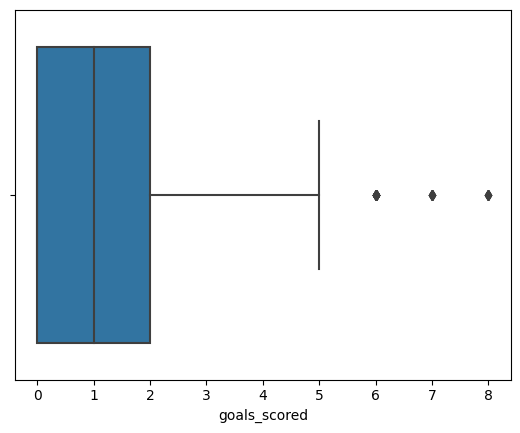

In [45]:
sns.boxplot(x=df_ml['goals_scored'])

<Axes: xlabel='xG'>

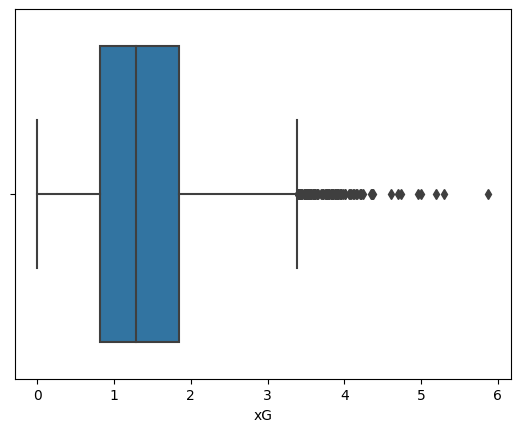

In [46]:
sns.boxplot(x=df_ml['xG'])

### Model Goal Scoring Probabilities Using Poisson Distribution

In [52]:
df_ml.head()

,match_id,team_id,team,goals_scored,xG,opponent,goals_conceded,xGA,xG-xGA,points
0,1729190,13.0,Arsenal,2.0,1.165430,Nottingham-Forest,1.0,0.511499,0.653931,3
1,1729454,13.0,Arsenal,2.0,1.665947,Nottingham-Forest,1.0,0.779480,0.886467,3
2,1729293,167.0,Manchester-City,2.0,0.746141,Nottingham-Forest,0.0,0.823560,-0.077420,3
3,1729332,167.0,Manchester-City,2.0,1.251912,Nottingham-Forest,0.0,1.541531,-0.289619,3
4,1729247,29.0,West-Ham,3.0,1.826450,Nottingham-Forest,2.0,1.325815,0.500635,3


The Poisson distribution models the probability of a given number of goals being scored based on an average rate (λ), which, in this case, is the team's total xG.

In [50]:
# Maximum number of goals to consider 
max_goals = 5 

# Calculate goal probabilities for Team A and Team B 
team_goal_probs = [poisson.pmf(i, df_ml['xG']) for i in range(max_goals + 1)] 
opponent_goal_probs = [poisson.pmf(i, df_ml['xGA']) for i in range(max_goals + 1)]

### Determine Match Outcome Probabilities based on xG

match_probs represents the probability of Team scoring x goals and conceding y goals, based on the xG and xGA on that specific game

In [53]:
match_probs = np.outer(team_goal_probs, opponent_goal_probs)

In [54]:
# Probability of Team winning (Team A scores more than Team B) 
P_win = np.sum(np.tril(match_probs, -1)) 

# Probability of a draw (both teams score the same number of goals) 
P_draw = np.sum(np.diag(match_probs)) 

# Probability of Team losing (Team A scores fewer goals than Team B) 
P_loss = np.sum(np.triu(match_probs, 1)) 

### Determine Expected Points based on match Probabilities

In [56]:
expected_points = (3 * P_win) + (1 * P_draw)

## xP Calculation Summarized

In [69]:
def calculate_xP_based_on_xG(xG,xGA,max_goals=10):
    # Calculate goal probabilities for Team A and Team B 
    team_goal_probs = [poisson.pmf(i, xG) for i in range(max_goals + 1)] 
    opponent_goal_probs = [poisson.pmf(i, xGA) for i in range(max_goals + 1)]

    match_probs = np.outer(team_goal_probs, opponent_goal_probs)

    # Probability of Team winning, drawing or losing 
    P_win = np.sum(np.tril(match_probs, -1)) 
    P_draw = np.sum(np.diag(match_probs)) 
    P_loss = np.sum(np.triu(match_probs, 1)) 

    # Expected Points calculation
    expected_points = (3 * P_win) + (1 * P_draw)

    return expected_points, P_win, P_draw, P_loss

In [70]:
# Apply the function to each row of the DataFrame and add new columns
df_ml[['expected_points', 'P_win', 'P_draw', 'P_loss']] = df_ml.apply(
    lambda row: pd.Series(calculate_xP_based_on_xG(row['xG'], row['xGA'])),
    axis=1)

In [71]:
df_ml.head()

,match_id,team_id,team,goals_scored,xG,opponent,goals_conceded,xGA,xG-xGA,points,expected_points,P_win,P_draw,P_loss
0,1729190,13.0,Arsenal,2.0,1.165430,Nottingham-Forest,1.0,0.511499,0.653931,3,1.880856,0.521572,0.316140,0.162288
1,1729454,13.0,Arsenal,2.0,1.665947,Nottingham-Forest,1.0,0.779480,0.886467,3,1.997388,0.585286,0.241531,0.173182
2,1729293,167.0,Manchester-City,2.0,0.746141,Nottingham-Forest,0.0,0.823560,-0.077420,3,1.254557,0.299177,0.357027,0.343796
3,1729332,167.0,Manchester-City,2.0,1.251912,Nottingham-Forest,0.0,1.541531,-0.289619,3,1.178364,0.309407,0.250144,0.440448
4,1729247,29.0,West-Ham,3.0,1.826450,Nottingham-Forest,2.0,1.325815,0.500635,3,1.705655,0.492336,0.228646,0.279014


## Team Analysis

In [77]:
df_ml['Points-xP'] = df_ml['points']-df_ml['expected_points']

In [78]:
columns_to_sum = ['xG', 'goals_scored', 'goals_conceded', 'xGA','xG-xGA','points','expected_points','Points-xP']  

In [79]:
# Group by 'team_id' and aggregate with 'first' for 'team_name'
df_ml_grouped = df_ml.groupby('team_id').agg({
    'team': 'first',  # Get the first team name
    **{col: 'sum' for col in columns_to_sum}  # Sum for other columns
}).reset_index()

# Now, sort by 'xG' in descending order
df_ml_grouped.sort_values(by='expected_points', ascending=False, inplace=True)

# Reset the index
df_ml_grouped.reset_index(drop=True, inplace=True)

In [80]:
df_ml_grouped.head()

,team_id,team,xG,goals_scored,goals_conceded,xGA,xG-xGA,points,expected_points,Points-xP
0,129.0,PSV-Eindhoven,93.990016,111.0,21.0,27.103748,66.886269,91,80.273252,10.726748
1,13.0,Arsenal,79.229722,91.0,29.0,30.360062,48.869660,89,80.052827,8.947173
2,256.0,Feyenoord,84.632837,92.0,26.0,20.358860,64.273978,84,79.782421,4.217579
3,167.0,Manchester-City,78.847878,96.0,34.0,32.949798,45.898080,91,78.306215,12.693785
4,75.0,Inter,77.622950,89.0,22.0,34.195375,43.427574,94,76.729555,17.270445


<Axes: xlabel='Points-xP'>

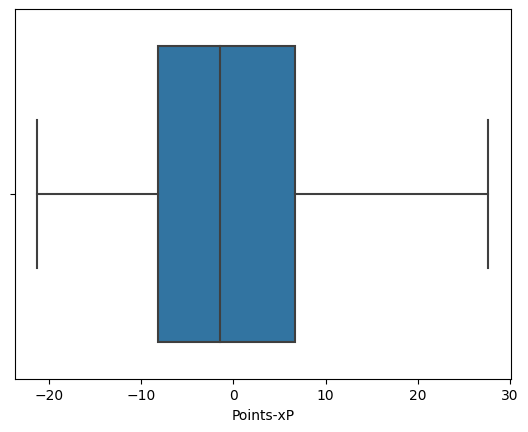

In [81]:
sns.boxplot(x=df_ml_grouped['Points-xP'])

In [82]:
#analyse par league

<Axes: xlabel='xG', ylabel='points'>

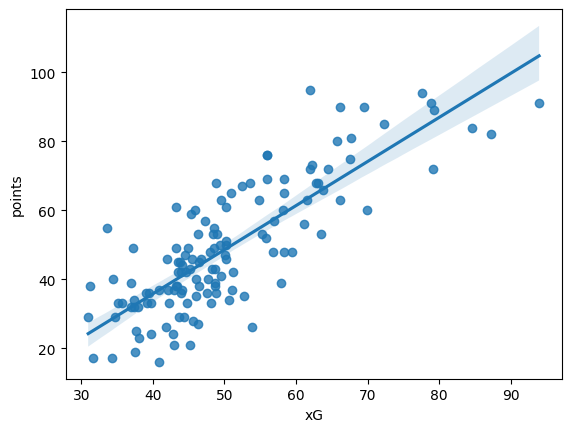

In [76]:
sns.regplot(data = df_ml_grouped ,x ='xG',y='points')

<Axes: xlabel='expected_points', ylabel='points'>

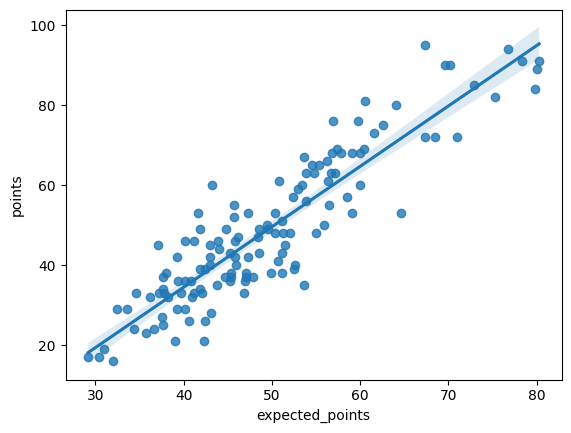

In [74]:
sns.regplot(data = df_ml_grouped ,x ='expected_points',y='points')

In [99]:
def generate_match_analysis(df_ml, match_id, max_goals=5):
    # Filter the match by match_id
    match = df_ml[df_ml['match_id'] == match_id].iloc[0]
    
    # Get the team names, xG, goals, and probabilities from the DataFrame
    team_1 = match['team']
    team_1_goals = int(match['goals_scored'])
    team_1_xG = match['xG']
    
    team_2 = match['opponent']
    team_2_goals = int(match['goals_conceded'])
    team_2_xGA = match['xGA']
    
    # Retrieve the probabilities of win, draw, and loss from the DataFrame
    P_win_team_1 = match['P_win']
    P_draw = match['P_draw']
    P_win_team_2 = match['P_loss']
    
    # Compute Poisson probabilities for goal distributions
    gProbs_team_1 = [poisson.pmf(i, team_1_xG) for i in range(max_goals + 1)]
    gProbs_team_2 = [poisson.pmf(i, team_2_xGA) for i in range(max_goals + 1)]
    
    # Plot the histograms for each team's goal distribution (based on their xG)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Team 1 goal probability histogram
    bars_team_1 = ax[0].bar(range(max_goals + 1), gProbs_team_1, color='orange')
    ax[0].set_title(f'Likelihood of {team_1} scoring')
    ax[0].set_xlabel('Goals')
    ax[0].set_ylabel('Probability')

    # Highlight the actual goals scored by Team 1
    bars_team_1[team_1_goals].set_color('green')
    
    # Add xG vertical line for Team 1
    ax[0].axvline(team_1_xG, linestyle='--', color='red')
    ax[0].text(team_1_xG + 0.1, max(gProbs_team_1) * 0.5, 'xG', color='red')

    # Team 2 goal probability histogram (horizontal)
    bars_team_2 = ax[1].barh(range(max_goals + 1), gProbs_team_2, color='orange')
    ax[1].set_title(f'Likelihood of {team_2} scoring')
    ax[1].set_xlabel('Probability')
    ax[1].set_ylabel('Goals')

    # Highlight the actual goals conceded by Team 2
    bars_team_2[team_2_goals].set_color('green')
    
    # Add xGA vertical line for Team 2
    ax[1].axhline(team_2_xGA, linestyle='--', color='red')
    ax[1].text(max(gProbs_team_2) * 0.5, team_2_xGA + 0.1, 'xGA', color='red')

    plt.tight_layout()
    plt.show()

    # Create a heatmap for the scoreline probabilities
    match_probs = np.outer(gProbs_team_1, gProbs_team_2)
    plt.figure(figsize=(8, 6))
    sns.heatmap(match_probs, annot=True, fmt='.1%', cmap='Reds', cbar=False)
    plt.title(f'Probability of every final score: {team_1} {team_1_goals} vs {team_2} {team_2_goals}', fontsize=14)
    plt.xlabel(f'{team_2} goals')
    plt.ylabel(f'{team_1} goals')

    # Display the probabilities of win, draw, and loss from your DataFrame
    plt.text(max_goals + 1, 1, f'{team_1} win: {P_win_team_1:.1%}', fontsize=12, color='green')
    plt.text(max_goals + 1, 2, f'Draw: {P_draw:.1%}', fontsize=12, color='blue')
    plt.text(max_goals + 1, 3, f'{team_2} win: {P_win_team_2:.1%}', fontsize=12, color='red')

    plt.show()

    print(f"Probability of {team_1} win: {P_win_team_1:.2%}")
    print(f"Probability of Draw: {P_draw:.2%}")
    print(f"Probability of {team_2} win: {P_win_team_2:.2%}")

In [100]:
match_id = 1729190

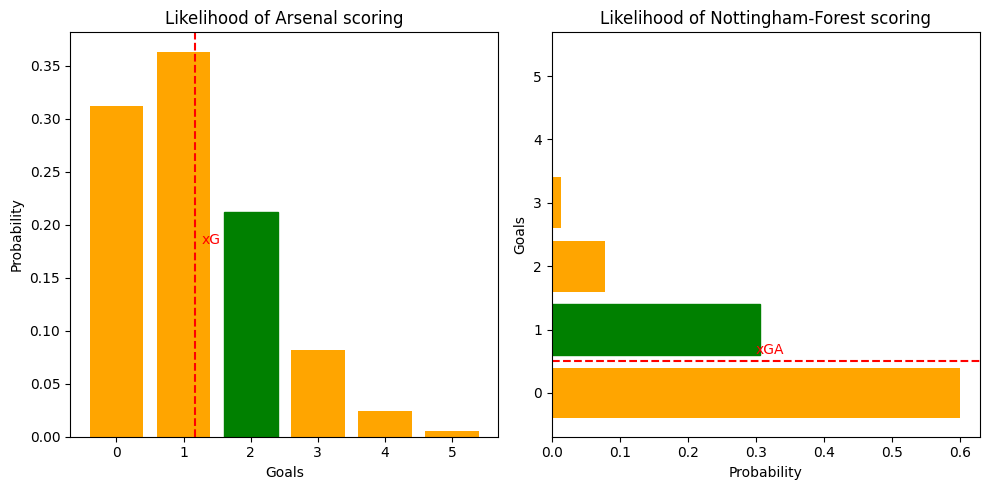

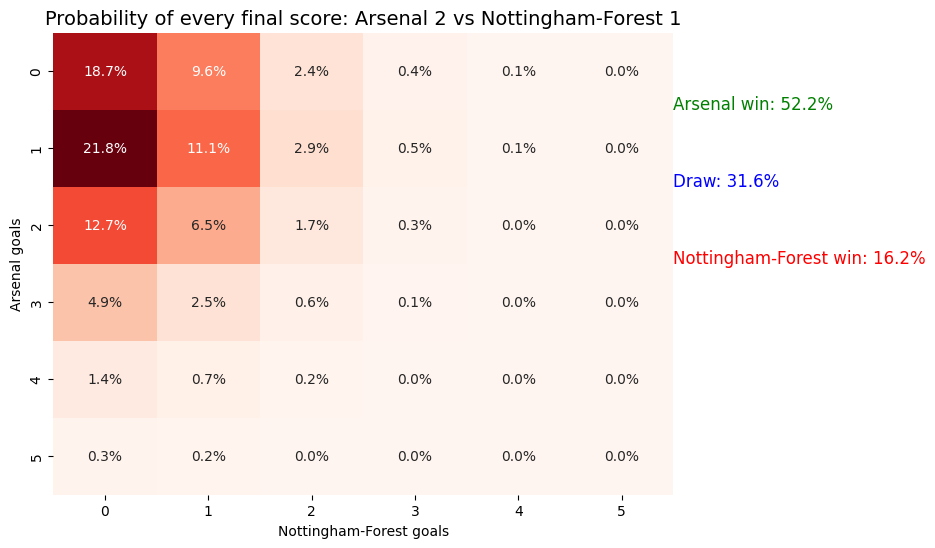

Probability of Arsenal win: 52.16%
Probability of Draw: 31.61%
Probability of Nottingham-Forest win: 16.23%


In [101]:
generate_match_analysis(df_ml, match_id, max_goals=5)

In [233]:
selected_team = 'Bayern-Munich'
df_ml_team = df_ml[df_ml['team']==selected_team]
df_ml_team

,match_id,team_id,team,goals_scored,xG,opponent,goals_conceded,xGA,xG-xGA,points,expected_points,P_win,P_draw,P_loss,Points-xP
1375,1743544,37.0,Bayern-Munich,1.0,2.259012,Union-Berlin,0.0,0.332860,1.926152,3,2.590220,0.815841,0.142696,0.041438,0.409780
1376,1743653,37.0,Bayern-Munich,5.0,1.779164,Union-Berlin,1.0,1.789927,-0.010763,3,1.383231,0.387613,0.220394,0.391988,1.616769
1399,1743402,37.0,Bayern-Munich,3.0,2.230621,Augsburg,1.0,0.648705,1.581917,3,2.377167,0.735042,0.172040,0.092895,0.622833
1400,1743515,37.0,Bayern-Munich,3.0,1.621210,Augsburg,2.0,2.534875,-0.913665,3,0.901075,0.238486,0.185617,0.575826,2.098925
1429,1743436,37.0,Bayern-Munich,2.0,1.741017,RB-Leipzig,2.0,1.158592,0.582424,1,1.766732,0.510132,0.236335,0.253530,-0.766732
1430,1743571,37.0,Bayern-Munich,2.0,1.447373,RB-Leipzig,1.0,0.596404,0.850969,3,2.005861,0.579309,0.267934,0.152757,0.994139
1463,1743463,37.0,Bayern-Munich,8.0,4.107515,Darmstadt,0.0,0.542948,3.564567,3,2.846748,0.933533,0.046149,0.016861,0.153252
1464,1743624,37.0,Bayern-Munich,5.0,3.824130,Darmstadt,2.0,0.601329,3.222800,3,2.800229,0.913411,0.059995,0.024570,0.199771
1489,1743490,37.0,Bayern-Munich,3.0,2.517208,Hoffenheim,0.0,1.275007,1.242200,3,2.110825,0.644140,0.178404,0.177390,0.889175
1490,1743693,37.0,Bayern-Munich,2.0,1.230478,Hoffenheim,4.0,1.820733,-0.590255,0,1.003837,0.258055,0.229671,0.512270,-1.003837


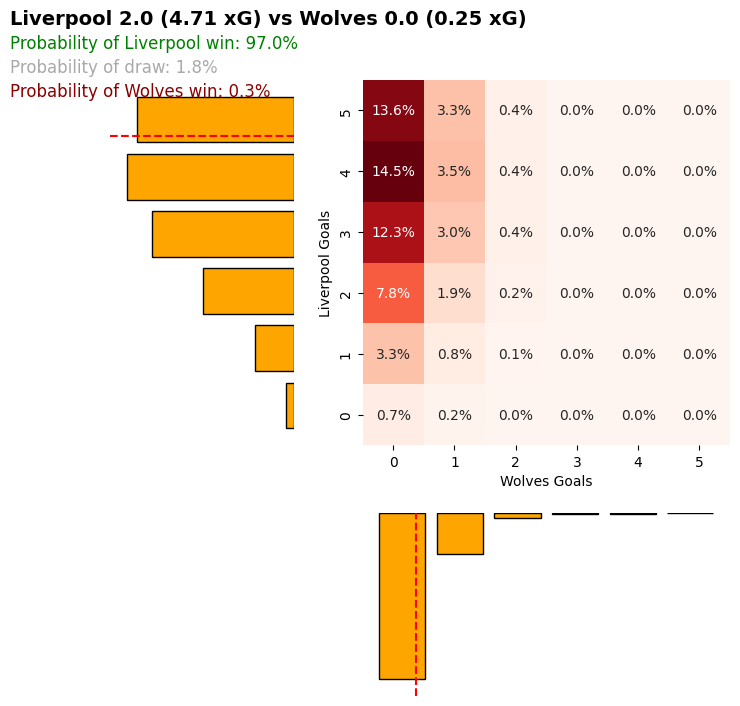

In [201]:
def generate_match_analysis_aligned(df_ml, match_id, max_goals=5):
    # Extract data for the specific match_id
    match_data = df_ml[df_ml['match_id'] == match_id]
    team_1 = match_data.iloc[0]['team']
    team_1_goals = match_data.iloc[0]['goals_scored']
    team_1_xG = match_data.iloc[0]['xG']
    
    team_2 = match_data.iloc[0]['opponent']
    team_2_goals = match_data.iloc[0]['goals_conceded']
    team_2_xGA = match_data.iloc[0]['xGA']
    
    P_win_team_1 = match_data.iloc[0]['P_win']
    P_draw = match_data.iloc[0]['P_draw']
    P_win_team_2 = match_data.iloc[0]['P_loss']

    # Generate Poisson probabilities
    gProbs_team_1 = [poisson.pmf(i, team_1_xG) for i in range(max_goals + 1)]
    gProbs_team_2 = [poisson.pmf(i, team_2_xGA) for i in range(max_goals + 1)]
    
    # Generate probability matrix for final score
    final_score_probs = np.outer(gProbs_team_1, gProbs_team_2)
    
    # Create the figure and gridspec layout
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 2], height_ratios=[2, 1], wspace=0.25, hspace=0.25)
    
    # Team 1 Bar Plot (aligned with heatmap Y-axis)
    ax_bar_team_1 = fig.add_subplot(gs[0, 0])
    ax_bar_team_1.barh(range(max_goals + 1), gProbs_team_1, color='orange', edgecolor='black')
    #bars_team_1 = ax_bar_team_1.barh(range(max_goals + 1), gProbs_team_1, color='orange', edgecolor='black')
    #bars_team_1[team_1_goals].set_color('green')  
    ax_bar_team_1.set_xlim(0, max(gProbs_team_1) * 1.1)
    ax_bar_team_1.axhline(team_1_xG, color='red', linestyle='--')
    ax_bar_team_1.invert_xaxis()
    #ax_bar_team_1.invert_yaxis()
    ax_bar_team_1.set_ylabel(f'{team_1} Goals')
    ax_bar_team_1.axis('off')

    
    # Team 2 Bar Plot (aligned with heatmap X-axis)
    ax_bar_team_2 = fig.add_subplot(gs[1, 1])
    ax_bar_team_2.bar(range(max_goals + 1), gProbs_team_2, color='orange', edgecolor='black')
    #bars_team_2 = ax_bar_team_2.barh(range(max_goals + 1), gProbs_team_2, color='orange', edgecolor='black')
    #bars_team_2[team_2_goals].set_color('green')
    ax_bar_team_2.axvline(team_2_xGA, color='red', linestyle='--')
    ax_bar_team_2.set_ylim(0, max(gProbs_team_2) * 1.1)
    ax_bar_team_2.set_xlabel(f'{team_2} Goals')
    ax_bar_team_2.invert_yaxis()
    ax_bar_team_2.axis('off')

    
    # Heatmap of final score probabilities
    ax_heatmap = fig.add_subplot(gs[0, 1])
    sns.heatmap(final_score_probs, annot=True, fmt='.1%', cmap='Reds', cbar=False,
                xticklabels=range(max_goals + 1), yticklabels=range(max_goals + 1),
                ax=ax_heatmap)
    ax_heatmap.invert_yaxis()
    #ax_heatmap.invert_xaxis()

    ax_heatmap.set_ylabel(f'{team_1} Goals')
    ax_heatmap.set_xlabel(f'{team_2} Goals')
    
    # Update plt.figtext section
    plt.figtext(0, 0.95, f"{team_1} {team_1_goals} ({team_1_xG:.2f} xG) vs {team_2} {team_2_goals} ({team_2_xGA:.2f} xG)",
                ha='left', fontsize=14, fontweight='bold')
    
    plt.figtext(0, 0.92, f"Probability of {team_1} win: {P_win_team_1*100:.1f}%", ha='left', fontsize=12, color='green')
    
    plt.figtext(0, 0.89, f"Probability of draw: {P_draw*100:.1f}%", ha='left', fontsize=12, color='darkgrey')
    
    plt.figtext(0, 0.86, f"Probability of {team_2} win: {P_win_team_2*100:.1f}%", ha='left', fontsize=12, color='darkred')

    plt.tight_layout()
    plt.show()

# Example usage
match_id = 1729428  # Replace with any match_id from your dataset
generate_match_analysis_aligned(df_ml, match_id, max_goals=5)

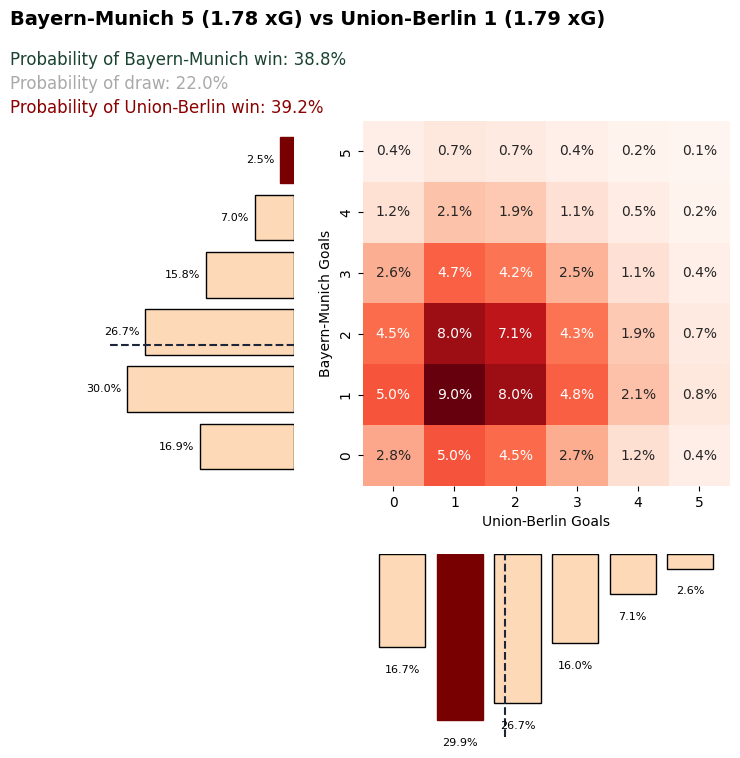

In [235]:
def generate_match_analysis_aligned(df_ml, match_id, max_goals=5):
    # Extract data for the specific match_id
    match_data = df_ml[df_ml['match_id'] == match_id]
    team_1 = match_data.iloc[0]['team']
    team_1_goals = int(match_data.iloc[0]['goals_scored'])  # Convert to int
    team_1_xG = match_data.iloc[0]['xG']
    
    team_2 = match_data.iloc[0]['opponent']
    team_2_goals = int(match_data.iloc[0]['goals_conceded'])  # Convert to int
    team_2_xGA = match_data.iloc[0]['xGA']
    
    P_win_team_1 = match_data.iloc[0]['P_win']
    P_draw = match_data.iloc[0]['P_draw']
    P_win_team_2 = match_data.iloc[0]['P_loss']

    # Generate Poisson probabilities
    gProbs_team_1 = [poisson.pmf(i, team_1_xG) for i in range(max_goals + 1)]
    gProbs_team_2 = [poisson.pmf(i, team_2_xGA) for i in range(max_goals + 1)]
    
    # Generate probability matrix for final score
    final_score_probs = np.outer(gProbs_team_1, gProbs_team_2)
    
    # Create the figure and gridspec layout
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 2], height_ratios=[2, 1], wspace=0.25, hspace=0.25)  # Adjusted hspace
    
    # Colors and green goal bar settings
    bar_color = '#fed9b7'  # Updated bar color
    goal_color = '#780000'  # For the actual goals
    
    # Team 1 Bar Plot (aligned with heatmap Y-axis)
    ax_bar_team_1 = fig.add_subplot(gs[0, 0])
    bars_team_1 = ax_bar_team_1.barh(range(max_goals + 1), gProbs_team_1, color=bar_color, edgecolor='black')
    bars_team_1[team_1_goals].set_color(goal_color)  # Set the actual goals bar to green
    ax_bar_team_1.set_xlim(0, max(gProbs_team_1) * 1.1)
    ax_bar_team_1.axhline(team_1_xG, color='#1b263b', linestyle='--')
    ax_bar_team_1.invert_xaxis()
    ax_bar_team_1.set_ylabel(f'{team_1} Goals')
    ax_bar_team_1.axis('off')
    
    # Add subtle percentages to each bar for Team 1
    for i, prob in enumerate(gProbs_team_1):
        ax_bar_team_1.text(prob + 0.01, i, f'{prob*100:.1f}%', va='center', ha='right', fontsize=8, color='black')

    # Team 2 Bar Plot (aligned with heatmap X-axis)
    ax_bar_team_2 = fig.add_subplot(gs[1, 1])
    bars_team_2 = ax_bar_team_2.bar(range(max_goals + 1), gProbs_team_2, color=bar_color, edgecolor='black')
    bars_team_2[team_2_goals].set_color(goal_color)  # Set the actual goals bar to green
    ax_bar_team_2.axvline(team_2_xGA, color='#1b263b', linestyle='--')
    ax_bar_team_2.set_ylim(0, max(gProbs_team_2) * 1.1)
    ax_bar_team_2.set_xlabel(f'{team_2} Goals')
    ax_bar_team_2.invert_yaxis()
    ax_bar_team_2.axis('off')
    
    # Add subtle percentages to each bar for Team 2
    for i, prob in enumerate(gProbs_team_2):
        ax_bar_team_2.text(i, prob + 0.05, f'{prob*100:.1f}%', va='bottom', ha='center', fontsize=8, color='black')
    
    # Heatmap of final score probabilities
    ax_heatmap = fig.add_subplot(gs[0, 1])
    sns.heatmap(final_score_probs, annot=True, fmt='.1%', cmap='Reds', cbar=False,
                xticklabels=range(max_goals + 1), yticklabels=range(max_goals + 1),
                ax=ax_heatmap)
    ax_heatmap.invert_yaxis()
    ax_heatmap.set_ylabel(f'{team_1} Goals')
    ax_heatmap.set_xlabel(f'{team_2} Goals')
    
    # Update plt.figtext section (adjusted y-position to prevent overlap)
    plt.figtext(0, 1, f"{team_1} {team_1_goals} ({team_1_xG:.2f} xG) vs {team_2} {team_2_goals} ({team_2_xGA:.2f} xG)",
                ha='left', fontsize=14, fontweight='bold')
    
    plt.figtext(0, 0.95, f"Probability of {team_1} win: {P_win_team_1*100:.1f}%", ha='left', fontsize=12, color='#1b4332')
    
    plt.figtext(0, 0.92, f"Probability of draw: {P_draw*100:.1f}%", ha='left', fontsize=12, color='darkgrey')
    
    plt.figtext(0, 0.89, f"Probability of {team_2} win: {P_win_team_2*100:.1f}%", ha='left', fontsize=12, color='darkred')

    plt.tight_layout()
    plt.show()

# Example usage
match_id = 1743653  # Replace with any match_id from your dataset
generate_match_analysis_aligned(df_ml, match_id, max_goals=5)

In [ ]:
# zid pourcentage
# habet l team 2 lel louta 
# dhaher l score bel lakdher 
# xps 2024/25